<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod6/dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod6/dnn.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

Training Deep Neural Networks
---
_homl3 ch11_

- A DNN has 10 and more layers
- each layer contains hundreds of neurons linked by hundreds of thousands of connections
- i.e. there are hundreds of thousands even millions of parameters


Problems in training DNNs
---
- gradients growing ever smaller or larger during backpropagating the DNN
  - called the `vanishing and exploding gradients` problems
  - both make lower layers very hard to train
- `insufficient data` for such a large DNN,
  - or it might be too costly to label, e.x. 
  - can be tackled with `transfer learning and unsupervised pretraining`
- A model with millions of parameters would severely risk `overfitting` the training set
  - especially if there are not enough training instances 
  - or if they are too noisy
  - can be tackled with `regularization techniques`
- Training may be extremely `slow`
  - can be tackled with various `optimizers` that can speed up training large models tremendously

In [1]:
import sys
if "google.colab" in sys.modules:
  %pip install -q -U keras-tuner

In [65]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

import tensorflow as tf, keras_tuner as kt, math

# The Vanishing and Exploding Gradients Problems
- the backprop backward step propagates the error gradient from the output layer to the input layer
  - computes the gradient of the cost function with regard to each parameter in the network
  - then uses these gradients to update each parameter with a gradient descent step
- Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers
  - As a result, the gradient descent update leaves the lower layers’ connection weights virtually unchanged
  - and training never converges to a good solution
  - This is called the `vanishing gradients problem`
- In some cases, the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges
  - This is the `exploding gradients problem`
  - often happens in recurrent neural networks
- More generally, DNNs suffer from `unstable gradients`
  - different layers may learn at widely different speeds

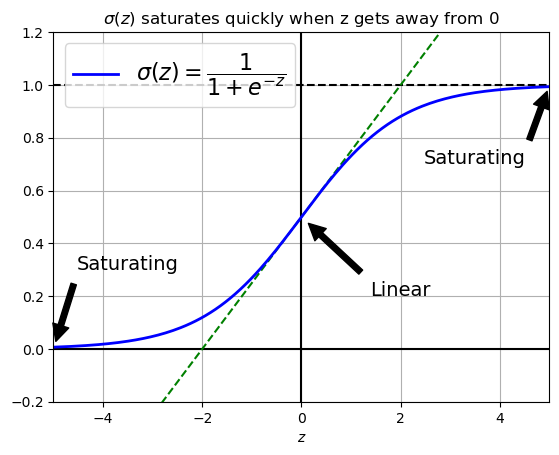

In [3]:
# 1. the sigmoid (logistic) activation function saturates quickly
#    when z gets away from 0 
#    i.e. the derivative gets very small

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

fig1, ax1 = plt.subplots()
ax1.plot([-5, 5], [0, 0], 'k-')
ax1.plot([-5, 5], [1, 1], 'k--')
ax1.plot([0, 0], [-0.2, 1.2], 'k-')
ax1.plot([-5, 5], [-3/4, 7/4], 'g--')
ax1.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
ax1.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
ax1.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
ax1.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
ax1.grid(True)
ax1.axis([-5, 5, -0.2, 1.2])
ax1.set_xlabel("$z$")
ax1.legend(loc="upper left", fontsize=16);
ax1.set_title(r"$\sigma(z)$" " saturates quickly when z gets away from 0");

Suspect caused the vanishing gradient problem
---
- the combination of sigmoid activation function and weight initialization technique ℕ(0,1)
  - causes the variance keeps increasing after each layer 
  - until the activation function saturates at the top layers
- this saturation is made worse due that 
  - the sigmoid function has a mean of 0.5, not 0
  - the hyperbolic tangent function has a mean of 0 
    - so it behaves slightly better than the sigmoid function
- ∴ there is almost no gradient to propagate back through the network
  - what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers
  - so there is really nothing left for the lower layers

Glorot or Xavier Initialization 
---
when using the `sigmoid` activation function, `Glorot initialization` significantly 
- alleviates the unstable gradients problem
  - speeds up training considerably 
  - becomes one of the practices that led to the success of deep learning
- initializes the weights of each layer randomly with
  - normal distribution: ${\displaystyle N(0,σ^2)}$ where  ${\displaystyle σ^2=\frac{1}{\operatorname{fan}_{avg}}}$, or
  - uniform distribution: ${\displaystyle {\displaystyle {\mathcal {U}}_{[-r,r]}}}$ where ${\displaystyle r=\sqrt{\dfrac{3}{\operatorname{fan}_{avg}}} = \sqrt{3}\sigma }$
  - ${\displaystyle \operatorname{fan}_{avg} = \dfrac{ \operatorname{fan}_{in}} {\operatorname{fan}_{out}}}$
  - the numbers of inputs and outputs of a layer are called the `fan-in` and `fan-out` of the layer
- `LeCun initialization` replaces $fan_{avg}$ with $fan_{in}$
  - equivalent to Glorot initialization when $fan_{in} = fan_{out}$

He Initialization 
---
- similar strategies have been proposed for different activation functions
  - they differ only by the scale of the variance and whether they use $fan_{avg}$ or $fan_{in}$
- The initialization strategy proposed for the `ReLU` activation function and its variants is called `He initialization` or `Kaiming initialization`
- Initialization parameters for each type of activation function

| Initialization |  Activation functions | σ² (Normal) |
|:--:|:--:|:--:|
| Glorot |  None, tanh, sigmoid, softmax |  $1 / fan_{avg}$ |
| He | ReLU, Leaky ReLU, ELU, GELU, Swish, Mish | $2 / fan_{in}$ |
| LeCun |  SELU | $1 / fan_{in}$ |


In [4]:
# 1. Glorot and He Initialization
# 1) Keras uses `Glorot` initialization with a uniform distribution by default
#    you can switch to `He` initialization by setting
#    kernel_initializer=​ "he_uniform" or "he_normal"

dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

# 2) you can obtain any of the initializations in the table above and more
#    using the `VarianceScaling` initializer
# e.g. use He initialization with a uniform distribution and 
# based on fanavg (rather than fanin)

he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

Better Activation Functions
---
- `ReLU` 
  - does not saturate for positive values and it is very fast to compute
  - but it suffers the problem of `dying ReLUs` because it saturates when z is negative
    - when the weighted sum of a neuron’s inputs plus its bias term is negative for all instances in the training set, the neuron outputs 0 only
    - i.e. the gradient descent stops working because the gradient of the ReLU function is zero when its input is negative
  - this problem can be solved with `Leaky ReLU'
- `Leaky ReLU`
  - defined as $LeakyReLU_\alpha(z)$ = max(αz, z)
  - The hyperparameter α defines how much the function “leaks”: 
    - it is the slope of the function for z < 0
  - `randomized leaky ReLU (RReLU)` is where 
    - α is picked randomly in a given range during training 
    - and is fixed to an average value during testing
  - `parametric leaky ReLU (PReLU)` is where
    - α is a parameter that can be tuned by backprop like any other parameter
- ReLU, leaky ReLU, and PReLU are all `not smooth` function
  - their derivatives abruptly change at z = 0
  - this sort of discontinuity can make gradient descent bounce around the optimum, 
  - and slow down convergence


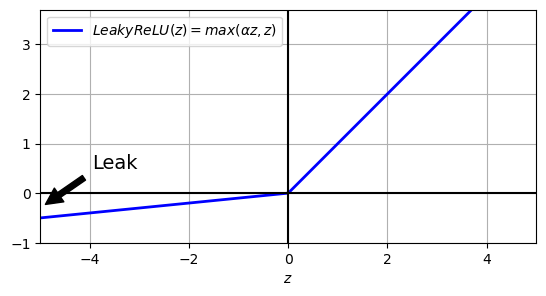

In [5]:
# 1. LeakyReLU

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
fig2, ax2 = plt.subplots()
ax2.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
ax2.plot([-5, 5], [0, 0], 'k-')
ax2.plot([0, 0], [-1, 3.7], 'k-')
ax2.grid(True)
props = dict(facecolor='black', shrink=0.1)
ax2.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
ax2.set_xlabel("$z$")
ax2.axis([-5, 5, -1, 3.7])
ax2.set_aspect("equal")
ax2.legend();

In [6]:
# 2. Keras includes the classes `LeakyReLU` and `PReLU`
#    they should be used with He initialization

leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # default alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [7]:
# 2.1 LeakyReLU can be used as a separate layer
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

2024-03-15 09:58:44.436711: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 09:58:44.505408: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


ELU and SELU
---
- two `smooth` variants of the ReLU
- `exponential linear unit (ELU)`
  - ${\displaystyle ELU_{\alpha}(z) =  {\begin{cases}\alpha \left(e^{z}-1\right)&{\text{if }}z< 0\\z&{\text{if }}z \ge 0\end{cases}}}$
  - If α = 1 then ELU is smooth everywhere
- `scaled ELU (SELU)`
  - ${\displaystyle SELU_{\lambda, \alpha}(z)\lambda {\begin{cases}\alpha (e^{z}-1)&{\text{if }}z<0\\z&{\text{if }}z\geq 0\end{cases}}}$
  - λ=1.0507 and α=1.67326
  - if SELU is used in all hidden layers of an NN with only dense layers
  - then the NN will self-normalize: 
    - the output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, 
    - which solves the vanishing/exploding gradients problem
  - self-normalization needs further conditions below:
    - The input features must be standardized: mean 0 and standard deviation 1
    - Every hidden layer’s weights must be initialized using LeCun normal initialization
    - The self-normalizing property is only guaranteed with plain MLPs
    - You cannot use regularization techniques like $\ell_1$ or $\ell_2$ regularization, max-norm, batch-norm, or regular dropout

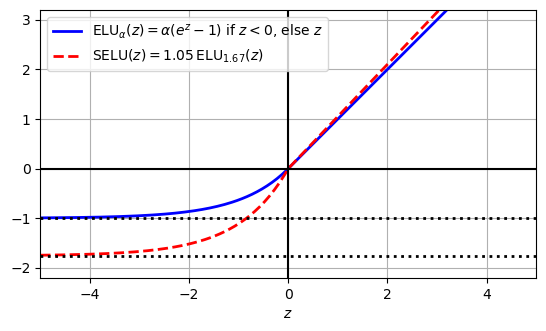

In [8]:
# 1. ELU and SELU

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
fig3, ax3 = plt.subplots()
ax3.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
ax3.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
ax3.plot([-5, 5], [0, 0], 'k-')
ax3.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
ax3.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
ax3.plot([0, 0], [-2.2, 3.2], 'k-')
ax3.grid(True)
ax3.axis([-5, 5, -2.2, 3.2])
ax3.set_xlabel("$z$")
ax3.set_aspect("equal")
ax3.legend();

In [9]:
# 2. apply ELU and SELU
elu_dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

selu_dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

In [10]:
# 3. SELU nn can regularize itself
# 1) create a nn for Fashion MNIST with 100 hidden layers, 
#    using the SELU activation function

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [12]:
# 2) load and normalize the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

4422102/4422102 [==============================] - 0s 0us/step


In [13]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [14]:
# 3) scale the inputs to mean 0 and standard deviation 1 before training the nn
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [15]:
# 4) The network managed to learn, despite it is 100 layers deep
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 20s 10ms/step - loss: 1.2365 - accuracy: 0.5214 - val_loss: 0.9275 - val_accuracy: 0.6668
Epoch 2/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.8455 - accuracy: 0.6919 - val_loss: 0.7271 - val_accuracy: 0.7418
Epoch 3/5
1719/1719 [==============================] - 18s 11ms/step - loss: 0.6934 - accuracy: 0.7476 - val_loss: 0.6378 - val_accuracy: 0.7704
Epoch 4/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.6339 - accuracy: 0.7713 - val_loss: 0.5832 - val_accuracy: 0.7910
Epoch 5/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.5878 - accuracy: 0.7850 - val_loss: 0.5693 - val_accuracy: 0.7978


In [16]:
# 4) however, same nn with RELU suffers from the vanishing/exploding gradients problem
#   its performance is much worse

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [18]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/5
1719/1719 [==============================] - 18s 9ms/step - loss: 1.9471 - accuracy: 0.2186 - val_loss: 1.8628 - val_accuracy: 0.1930
Epoch 2/5
1719/1719 [==============================] - 16s 9ms/step - loss: 1.5923 - accuracy: 0.3541 - val_loss: 1.9134 - val_accuracy: 0.3766
Epoch 3/5
1719/1719 [==============================] - 17s 10ms/step - loss: 1.2027 - accuracy: 0.5039 - val_loss: 0.9811 - val_accuracy: 0.6140
Epoch 4/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.9915 - accuracy: 0.5909 - val_loss: 0.9764 - val_accuracy: 0.5808
Epoch 5/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.8955 - accuracy: 0.6402 - val_loss: 0.7930 - val_accuracy: 0.6974


GELU, Swish, and Mish
---
- smooth, nonconvex, and nonmonotonic variants of ReLU
- `Gaussian Error Linear Unit (GELU)`
  - ${\displaystyle \operatorname {GELU}(z)=z\Phi(z) \approx z\sigma (1.702z) }$
  - Φ is the standard Gaussian cumulative distribution function
    - ${\displaystyle \Phi (z)={\frac {1}{\sqrt {2\pi }}}\int _{-\infty }^{z}e^{-t^{2}/2}\,dt}$
- `Swish`
  - ${\displaystyle \operatorname {swish}_{\beta} (z)=z\sigma (\beta z)={\frac {z}{1+e^{-\beta z}}}}$
  - β is like any other hyperparameter which can be tuned and trained
  - β=1, `zσ(z)` is called `sigmoid linear unit (SiLU)`
- `Mish`
  - similar to `Swish`, defined as
  - ${\displaystyle \operatorname {mish}(z) = z\tanh (\operatorname{softplus(z)}) = z\tanh (\log(1+e^z)) }$
- they all outperform ReLU but at the cost of more computing resources
- ReLU remains a good default for simple tasks
  - Swish and Mish are better default for more complex tasks

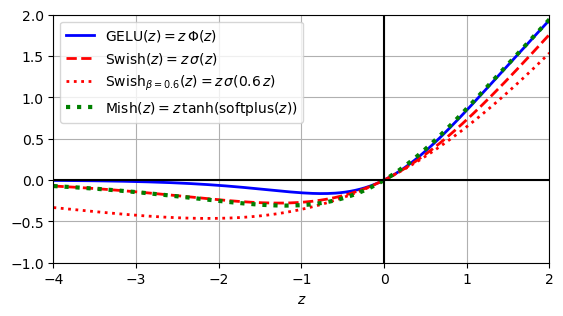

In [19]:
# 1. GELU, Swish, SiLU and Mish
def swish(z, beta=1):
    return z * tf.math.sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6

fig4, ax4 = plt.subplots()
ax4.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
ax4.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
ax4.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
ax4.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
ax4.plot([-4, 2], [0, 0], 'k-')
ax4.plot([0, 0], [-2.2, 3.2], 'k-')
ax4.grid(True)
ax4.axis([-4, 2, -1, 2])
ax4.set_aspect("equal")
ax4.set_xlabel("$z$")
ax4.legend(loc="upper left");

Batch Normalization (BN)
---
- a different way to solve the unstable gradients problem
- simply zero-centers and normalizes each input
  - then scales and shifts the result using two new parameter vectors per layer
    - one for scaling, the other for shifting
- no need to standardize the training set if a BN layer is added to the first layer of a NN
  - no need for StandardScaler or Normalization
  - the BN layer will do the task
- the BN algorithm on a mini-batch B of size m of the entire training set:
  - ${\displaystyle \boldsymbol{\mu} _{B}={\frac {1}{m}}\sum _{i=1}^{m}\mathbf{x}_{i}}$
    - the vector of input means
  - ${\displaystyle \boldsymbol{\sigma} _{B}^{2}={\frac {1}{m}}\sum _{i=1}^{m}(\mathbf{x}_{i}-\boldsymbol{\mu} _{B})^{2}}$
    - the vector of input standard deviations
  - ${\displaystyle {\hat{\mathbf{x}}_{i}^{(k)}={\frac {\mathbf{x}_{i}^{(k)}-\boldsymbol{\mu} _{B}^{(k)}}{\sqrt {\left(\boldsymbol{\sigma} _{B}^{(k)}\right)^{2}+\epsilon }}}}}$
    - the vector of zero-centered and normalized inputs
    - ε is the smoothing term, a tiny number that avoids division by zero and ensures the 
gradients don’t grow too large
  - ${\displaystyle \mathbf{z}_{i}^{(k)}=\boldsymbol{\gamma} ^{(k)} \otimes {\hat {\mathbf{x}}}_{i}^{(k)}+\boldsymbol{\beta} ^{(k)}}$
    - the output of the BN operation
    - γ is the output `scale` parameter vector for the layer
    - ⊗ represents element-wise multiplication
    - β is the output shift (`offset`) parameter vector for the layer

BN benefits, limits and fusion
---
- BN standardizes its inputs, then rescales and offsets them during training
- but it is complex during test since it predicts for individual instances rather than for batches of instances, two ways to solve this problem
  - `method 1`: at the end of training, run the whole training set through the nn and compute the mean and standard deviation of each input of the BN layer
  - use these final input means and standard deviations for predictions
  - `method 2`: estimate these final statistics during training by using a `moving average` of the layer’s input means and standard deviations
    - this is the default method for Keras `BatchNormalization` layer
- BN strongly reduced the vanishing gradients problem to the point that
  -  saturating activation functions such as `tanh` and `sigmoid` can be used
  -  the nn also becomes less sensitive to the weight initialization
  -  much larger learning rates are used to significantly speed up the learning process
- BN also acts like a regularizer reducing the need for other regularization techniques such as `dropout`
- but there is a runtime penalty: the nn makes slower predictions due to the extra computations required at each layer
  - this can be solved by `fusing` layer BNᵢ into its previous layer Lᵢ:
    - if Lᵢ computes $\mathbf{XW + b}$, 
    - then BNᵢ computes  $\mathbf{\boldsymbol{γ} ⊗ (XW + b – \boldsymbol{μ}) / \boldsymbol{σ} + \boldsymbol{β}}$
      - the smoothing term ε in the denominator is ignored
    - the fusion is replacing Lᵢ’s weights $\mathbf{W}$ and biases $\mathbf{b}$ by
      - $\mathbf{W′ = \boldsymbol{γ}⊗W / \boldsymbol{σ}}$ and $\mathbf{b′ = \boldsymbol{γ} ⊗ (b – \boldsymbol{μ}) / \boldsymbol{σ} + \boldsymbol{β}}$
      - ∴ the equation simplifies to $\mathbf{XW′ + b′}$

In [20]:
# 1. Apply batch normalization with Keras by
#  adding a BatchNormalization layer before or after each hidden layer’s activation function

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [21]:
# 1) each BN layer adds four parameters per input: γ, β, μ, and σ 
# e.g. BN1 adds 3,136 = 4*784 parameters
#  μ and σ, are the moving averages; they are not affected by backpropagation, 
#  so Keras calls them “non-trainable”
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [22]:
# trainable parameters in BN1
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [23]:
# 2) show the model works
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5502 - accuracy: 0.8075 - val_loss: 0.3973 - val_accuracy: 0.8548
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4044 - accuracy: 0.8562 - val_loss: 0.3637 - val_accuracy: 0.8724


In [24]:
# 3) Sometimes applying BN before the activation function works better
# Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, 
# since the `BatchNormalization` layer includes one offset parameter per input, 
# so you can remove the bias term from the previous layer by setting 
#  `use_bias=False` :

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [25]:
# 4) this model works as well
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6033 - accuracy: 0.7983 - val_loss: 0.4300 - val_accuracy: 0.8416
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4225 - accuracy: 0.8512 - val_loss: 0.3761 - val_accuracy: 0.8608


BN hyperparameter: momentum and axis
---
- `momentum` m is used to update the exponential moving averages $\hat{\mathbf{v}}$:
  - $\hat{\mathbf{v}} = \hat{\mathbf{v}}m + \mathbf{v}(1-m)$
  - given a new value $\mathbf{v}$ of input means or standard deviations computed over the current batch
  - m is  is typically close to 1 such as 0.9, 0.99, 0.999, etc.
    - more 9s for larger datasets and for smaller mini-batches
- `axis` determines which axis should be normalized
  -  defaults to –1, meaning that by default it will normalize the last axis
  -  e.g.  given batch shape [batch size, features], 
     -  each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch
- BN has become one of the most-used layers in DNNs
  - especially deep convolutional neural networks (CNN)

Gradient Clipping
---
- Another technique to mitigate the `exploding gradients problem`
- clips the gradients during backpropagation so that they never exceed some threshold
- generally used in recurrent neural networks (RNN)
- two types in Keras:
  - `clipvalue` may change the direction of the gradient vector
    - it clips all the partial derivatives of the loss to be between `-clipvalue` and `clipvalue`
  - `clipnorm` does not change the direction of the gradient vector
    - it clips the whole gradient if its $\ell_2$ norm is greater than `clipnorm`
    - but it may clip very small partial gradients

In [26]:
# 1. All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:
optimizer_cv = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_cv)

optimizer_cn = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_cn)

# Reusing Pretrained Layers
- `transfer learning` reuses most of an existent E model's layers to solve similar problems
  - speeds up training considerably
  - requires significantly less training data
- the lower layers of E, the more reusable, the upper the less
  - the output layer of E should usually be replaced
  - freeze all layers other than the output layer
    - then unfreeze the hidden layers from top to bottom one by one
    - train the model after each unfreezing to see how it performs
    - small learning rate is preferred to avoid wrecking old fine-tuned weights
    - top hidden layers could also be dropped even replaced
    - fresh new top hidden layers could be added
  - until the new model's performance is satisfied
 

In [27]:
# 1. transfer learning transfer the capabilities of model A to B
# in classifying the fashion MNIST
# - model A tackles the task of predicting 8 fashions except for 
#     T-shirts/tops and pullovers (classes 0 and 2)
# - model B tackles the task of predicting the 2 fashions model A missed
#     with a much smaller training set

# 1) create datasets from A and B
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]


# 2) build, train and save model A
model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 3s 2ms/step - loss: 1.1656 - accuracy: 0.6358 - val_loss: 0.6988 - val_accuracy: 0.7852
Epoch 2/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.6038 - accuracy: 0.8061 - val_loss: 0.5090 - val_accuracy: 0.8328
Epoch 3/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.4814 - accuracy: 0.8437 - val_loss: 0.4302 - val_accuracy: 0.8591
Epoch 4/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.4201 - accuracy: 0.8630 - val_loss: 0.3884 - val_accuracy: 0.8684
Epoch 5/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3828 - accuracy: 0.8732 - val_loss: 0.3606 - val_accuracy: 0.8767
Epoch 6/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3578 - accuracy: 0.8805 - val_loss: 0.3459 - val_accuracy: 0.8797
Epoch 7/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3402 - accuracy: 0.8856 - val_loss: 0.3296 - val_accuracy:

INFO:tensorflow:Assets written to: my_model_A/assets


In [28]:
# 3) train and evaluate model B, without reusing model A

model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6344 - accuracy: 0.6450 - val_loss: 0.6256 - val_accuracy: 0.6894
Epoch 2/20
7/7 [==============================] - 0s 7ms/step - loss: 0.6116 - accuracy: 0.7550 - val_loss: 0.6053 - val_accuracy: 0.7656
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5898 - accuracy: 0.7900 - val_loss: 0.5840 - val_accuracy: 0.8200
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5682 - accuracy: 0.8550 - val_loss: 0.5666 - val_accuracy: 0.8457
Epoch 5/20
7/7 [==============================] - 0s 6ms/step - loss: 0.5496 - accuracy: 0.8800 - val_loss: 0.5494 - val_accuracy: 0.8625
Epoch 6/20
7/7 [==============================] - 0s 6ms/step - loss: 0.5307 - accuracy: 0.9000 - val_loss: 0.5326 - val_accuracy: 0.8892
Epoch 7/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5135 - accuracy: 0.9000 - val_loss: 0.5171 - val_accuracy: 0.9021
Epoch 8/20
7/7 [=================

[0.376443475484848, 0.9369999766349792]

In [29]:
# 4) reuse the pretrained model A
model_A = tf.keras.models.load_model("my_model_A")

# reuse all layers except the output layer
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1]) 
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# freeze all reused layers
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [30]:
# 5) train the reused model
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 16ms/step - loss: 1.0522 - accuracy: 0.4750 - val_loss: 0.7703 - val_accuracy: 0.5302
Epoch 2/4
7/7 [==============================] - 0s 12ms/step - loss: 0.6839 - accuracy: 0.5950 - val_loss: 0.6515 - val_accuracy: 0.5915
Epoch 3/4
7/7 [==============================] - 0s 15ms/step - loss: 0.6090 - accuracy: 0.6800 - val_loss: 0.6086 - val_accuracy: 0.6785
Epoch 4/4
7/7 [==============================] - 0s 13ms/step - loss: 0.5844 - accuracy: 0.7050 - val_loss: 0.5961 - val_accuracy: 0.7033
Epoch 1/16
7/7 [==============================] - 0s 16ms/step - loss: 0.5569 - accuracy: 0.7500 - val_loss: 0.5617 - val_accuracy: 0.7319
Epoch 2/16
7/7 [==============================] - 0s 7ms/step - loss: 0.5185 - accuracy: 0.7600 - val_loss: 0.5001 - val_accuracy: 0.8220
Epoch 3/16
7/7 [==============================] - 0s 6ms/step - loss: 0.4653 - accuracy: 0.8450 - val_loss: 0.4586 - val_accuracy: 0.8615
Epoch 4/16
7/7 [=================

In [31]:
# 6) evaluate the reused model

model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 511us/step - loss: 0.2798 - accuracy: 0.9305


[0.27976080775260925, 0.9304999709129333]

In [32]:
# the performance is a little bit better than the fresh new model B above
# from 0.929 to 0.9355
# the error rate dropped by 9%
1 - (100 - 93.55)/(100 - 92.9)

0.09154929577464677

In [33]:
!rm -rf ./my_model_A/

Unsupervised Pretraining
---
- tackles situation S without sufficient labeled training data nor similar models
- `method 1`: trains an unsupervised model such as an autoencoder or a generative adversarial network (GAN)
  - replaced the early-day unsupervised pretraining technique which
    - trains one layer a time with restricted Boltzmann machines (RBMs)
  - then reuse the lower layers of the autoencoder or the lower layers of the GAN’s discriminator
  - add some hidden layers and an output layer on top to tackle S with supervised learning
- `method 2`: pretrains on an auxiliary task for which labeled training data can be easily obtained or generated
  -  then reuse the lower layers of the auxiliary network for the actual task

# Faster Optimizers
The following popular optimization algorithms can speed up DNN training:
- momentum
- Nesterov accelerated gradient
- AdaGrad
- RMSProp
- Adam and its variants

Momentum optimization
---
- gradient descent: ${ \boldsymbol{θ} ← \boldsymbol{θ} - η∇_{\boldsymbol{θ}}J(\boldsymbol{θ})  }$
  - the step size is proportional to the local gradient
  - it has no relationship with earlier gradients so it will never pick up speed
- `Momentum optimization` accumulates momentum from earlier gradients with the core idea: 
  - a raindrop starts out slowly but it will quickly pick up momentum until it eventually reaches terminal velocity
  - with the momentum, it can also help roll past local optima
- the momentum algorithm updates momentum vector $\mathbf{m}$ and parameter vector $\boldsymbol{θ}$:
  - ${ \mathbf{m} ← β\mathbf{m} − η∇_{\boldsymbol{θ}}J(\boldsymbol{θ}) }$
  - ${ \boldsymbol{θ} ← \boldsymbol{θ} + \mathbf{m} }$
  - hyperparameter β, called the momentum, which must be set between 0 (high friction) and 1 (no friction)
    - a typical momentum value is 0.9
    - used to overcome overshoot
  - if the gradient remains constant, the terminal velocity (i.e. the maximum size of the weight updates) equals ${ \mathbf{m} = \dfrac{-η}{1-β} ∇_{\boldsymbol{θ}}J(\boldsymbol{θ})}$
  - e.g. if β=0.9, it's 10 times faster than traditional gradient decent

Nesterov Accelerated Gradient (NAG)
---
- a variant of momentum optimization, also known as `Nesterov momentum optimization`
  - almost always faster than regular momentum optimization 
- measures the gradient of the cost function not at the local position $\boldsymbol{θ}$ 
  - but slightly ahead in the direction of the momentum, at ${ \boldsymbol{θ} + β\mathbf{m} }$
  - ${ \mathbf{m} ← β\mathbf{m} − η∇_{\boldsymbol{θ}}J(\boldsymbol{θ}+ β\mathbf{m}) }$
  - ${ \boldsymbol{θ} ← \boldsymbol{θ} + \mathbf{m} }$
  - in general the momentum vector will be pointing in the right direction
    - i.e., toward the optimum
    - this helps reduce oscillations and thus NAG converges faster

AdaGrad
---
- corrects gradient direction earlier to point a bit more toward the global optimum in problems such as the `elongated bowl problem`
  - by `scaling down the gradient vector` along the steepest dimensions
  - ❶ ${ \mathbf{s} ← \mathbf{s} + ∇_{\boldsymbol{θ}}J(\boldsymbol{θ}) ⊗ ∇_{\boldsymbol{θ}}J(\boldsymbol{θ}) }$
    -  accumulates the square of the gradients into the vector $\mathbf{s}$
    -  ⊗ represents the element-wise multiplication
    -  equivalent to compute ${ s_i ← s_i +  (∂ J(\boldsymbol{θ}) / ∂ θ_i)^2 }$
  - ❷ ${ \boldsymbol{θ} ← \boldsymbol{θ} - η∇_{\boldsymbol{θ}}J(\boldsymbol{θ})⊘\sqrt{\mathbf{s}+ε} }$
    -  equivalent to compute ${ θ_i ← θ_i − η \dfrac{∂J(\boldsymbol{θ})} {∂θ_i} / \sqrt{s_i + ε} }$
    -  almost identical to gradient descent but `scaled down` by a factor of ${ \sqrt{\mathbf{s}+ε} }$
    -  ⊘ represents the element-wise division 
    -  ε is a smoothing term to avoid division by zero, defaults to ${ 10^{-10} }$
- decays the learning rate η faster for steep dimensions than for dimensions with gentler slopes. 
  - this is called an `adaptive learning rate`
  - helps point the resulting updates more directly toward the global optimum
  - requires much less tuning of the learning rate
- performs well for simple quadratic problems
  - but it often stops too early to reach the global optimum when training NNs

RMSProp
---
- fixes the early stopping of AdaGrad 
  - by accumulating only the gradients from the most recent iterations
  - through `exponential decay` in step ❶
  - ❶ ${ \mathbf{s} ← ρ\mathbf{s} +  (1 − ρ) ∇_{\boldsymbol{θ}}J(\boldsymbol{θ}) ⊗ ∇_{\boldsymbol{θ}}J(\boldsymbol{θ}) }$
  - ❷ ${ \boldsymbol{θ} ← \boldsymbol{θ} - η∇_{\boldsymbol{θ}}J(\boldsymbol{θ})⊘\sqrt{\mathbf{s}+ε} }$
  - the decay rate ρ is typically set to 0.9 which works well
    - so you may not need to tune it at all
- Except on very simple problems, this optimizer almost always performs much better than AdaGrad

Adam
---
- `adaptive moment estimation (Adam)` combines the ideas of 
  - momentum optimization: 
    - keeps track of an exponentially `decaying average of past gradients`
  - and RMSProp:
    - keeps track of an exponentially decaying average of past `squared` gradients
  - these are estimations of the `mean (first moment)` and the uncentered `variance (second moment)`  of the gradients
- algorithm:
  - ❶ ${ \mathbf{m} ← β_1 \mathbf{m} − (1-β_1)∇_{\boldsymbol{θ}}J(\boldsymbol{θ}) }$
  - ❷ ${ \mathbf{s} ← β_2\mathbf{s} +  (1 − β_2) ∇_{\boldsymbol{θ}}J(\boldsymbol{θ}) ⊗ ∇_{\boldsymbol{θ}}J(\boldsymbol{θ}) }$
  - ❸ ${ \mathbf{\widehat{m}} = \dfrac{\mathbf{m}}{1-β_1^{(k)}}}$
  - ❹ ${ \mathbf{\widehat{s}} = \dfrac{\mathbf{s}}{1-β_2^{(k)}}}$
  - ❺ ${ \boldsymbol{θ} ← \boldsymbol{θ} - η\mathbf{\widehat{m}}⊘\sqrt{\mathbf{\widehat{s}}+ε} }$
  - k represents the iteration number
  - the `momentum decay` hyperparameter β₁ is typically initialized to 0.9
  - the `scaling decay` hyperparameter β₂ is often initialized to 0.999
  - the `smoothing` term ε is usually initialized to a tiny number such as 10⁻⁷
- as an `adaptive learning rate algorithm`
  - it requires less tuning of the learning rate hyperparameter η
  - the default value η = 0.001 is often used
- has three variants: AdaMax, Nadam, and AdamW

AdaMax
---
- replaces the ${ \ell_2 }$ norm used in Adam with ${\ell_∞}$ norm
  - specifically, replaces step ❷ with ${ \mathbf{s} ← \max (β_2\mathbf{s}, |∇_{\boldsymbol{θ}}J(\boldsymbol{θ})|) }$
- drops step ❹ 
- more stable than Adam but 
  - it really depends on the dataset
  - in general Adam performs better


Nadam
---
- Adam optimization plus the Nesterov trick
- often converges slightly faster than Adam
- Nadam generally outperforms Adam but is sometimes outperformed by RMSProp

AdamW
---
- a variant of Adam with a regularization technique called `weight decay`
- weight decay reduces the size of the model’s weights at each training iteration 
  - by multiplying them by a decay factor such as 0.99
  - equivalent to ${ \ell_2 }$ regularization when using SGD
  - but ${ \ell_2 }$ regularization and weight decay are not equivalent in Adam or its variants
- combining Adam with ${ \ell_2 }$ regularization results in models that often don’t generalize as well as those produced by SGD
  - AdamW fixes this issue by properly combining Adam with weight decay

Optimizer relative comparison
---
| Class | Convergence speed | Convergence quality |
|:--:|:--:|:--:|
| SGD | bad | good |
| SGD(momentum=...)<br>SGD(momentum=..., nesterov=True) | average | good |
| Adagrad | good | bad (stops too early) |
| RMSprop, Adam<br>AdaMax, Nadam, AdamW | good |  average or good | 


In [34]:
# 1. a small function to test optimizers on Fashion MNIST

def build_model():
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [35]:
# 0) sgd
optimizer0 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0)
history_sgd = build_and_train_model(optimizer0) 

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.4593 - accuracy: 0.5459 - val_loss: 0.9231 - val_accuracy: 0.7112
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8139 - accuracy: 0.7280 - val_loss: 0.7073 - val_accuracy: 0.7502
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6819 - accuracy: 0.7657 - val_loss: 0.6264 - val_accuracy: 0.7736
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6167 - accuracy: 0.7879 - val_loss: 0.5786 - val_accuracy: 0.7976
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5738 - accuracy: 0.8041 - val_loss: 0.5478 - val_accuracy: 0.8076
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5440 - accuracy: 0.8150 - val_loss: 0.5200 - val_accuracy: 0.8198
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5211 - accuracy: 0.8225 - val_loss: 0.5019 - val_accuracy:

In [36]:
# 1). momentum
optimizer1 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
history_momentum = build_and_train_model(optimizer1)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7240 - accuracy: 0.7550 - val_loss: 0.4881 - val_accuracy: 0.8302
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4727 - accuracy: 0.8342 - val_loss: 0.4294 - val_accuracy: 0.8502
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4248 - accuracy: 0.8512 - val_loss: 0.4013 - val_accuracy: 0.8558
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4007 - accuracy: 0.8594 - val_loss: 0.4094 - val_accuracy: 0.8518
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3799 - accuracy: 0.8663 - val_loss: 0.3822 - val_accuracy: 0.8622
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3660 - accuracy: 0.8697 - val_loss: 0.3830 - val_accuracy: 0.8634
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3517 - accuracy: 0.8742 - val_loss: 0.3593 - val_accuracy:

In [37]:
# 2). Nesterov accelerated gradient
optimizer2 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)
history_nesterov = build_and_train_model(optimizer2) 

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6826 - accuracy: 0.7722 - val_loss: 0.4686 - val_accuracy: 0.8360
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4627 - accuracy: 0.8383 - val_loss: 0.4318 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4233 - accuracy: 0.8521 - val_loss: 0.3996 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3988 - accuracy: 0.8600 - val_loss: 0.3992 - val_accuracy: 0.8562
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3789 - accuracy: 0.8651 - val_loss: 0.4002 - val_accuracy: 0.8640
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3648 - accuracy: 0.8709 - val_loss: 0.3620 - val_accuracy: 0.8682
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3502 - accuracy: 0.8740 - val_loss: 0.3606 - val_accuracy:

In [39]:
# 3). AdaGrad
optimizer3 = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer3)  

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.0348 - accuracy: 0.6619 - val_loss: 0.6880 - val_accuracy: 0.7626
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6432 - accuracy: 0.7850 - val_loss: 0.5806 - val_accuracy: 0.8002
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5681 - accuracy: 0.8089 - val_loss: 0.5345 - val_accuracy: 0.8138
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5300 - accuracy: 0.8194 - val_loss: 0.5079 - val_accuracy: 0.8198
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5068 - accuracy: 0.8266 - val_loss: 0.4917 - val_accuracy: 0.8264
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4898 - accuracy: 0.8323 - val_loss: 0.4754 - val_accuracy: 0.8300
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4770 - accuracy: 0.8364 - val_loss: 0.4651 - val_accuracy:

In [40]:
# 4). RMSProp
optimizer4 = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer4) 

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5197 - accuracy: 0.8119 - val_loss: 0.4207 - val_accuracy: 0.8462
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3923 - accuracy: 0.8593 - val_loss: 0.4390 - val_accuracy: 0.8356
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3686 - accuracy: 0.8683 - val_loss: 0.3824 - val_accuracy: 0.8704
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3553 - accuracy: 0.8747 - val_loss: 0.3833 - val_accuracy: 0.8742
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3527 - accuracy: 0.8764 - val_loss: 0.4166 - val_accuracy: 0.8690
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3494 - accuracy: 0.8782 - val_loss: 0.4274 - val_accuracy: 0.8668
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3473 - accuracy: 0.8796 - val_loss: 0.4311 - val_accuracy:

In [41]:
# 5) Adam
optimizer5 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)
history_adam = build_and_train_model(optimizer5) 

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4951 - accuracy: 0.8229 - val_loss: 0.4080 - val_accuracy: 0.8474
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3665 - accuracy: 0.8655 - val_loss: 0.3667 - val_accuracy: 0.8646
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3355 - accuracy: 0.8763 - val_loss: 0.3487 - val_accuracy: 0.8748
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3146 - accuracy: 0.8835 - val_loss: 0.3303 - val_accuracy: 0.8788
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2954 - accuracy: 0.8901 - val_loss: 0.3419 - val_accuracy: 0.8762
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2830 - accuracy: 0.8939 - val_loss: 0.3521 - val_accuracy: 0.8742
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2727 - accuracy: 0.8977 - val_loss: 0.3471 - val_accuracy:

In [42]:
# 6) Adamax
optimizer6 = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)
history_adamax = build_and_train_model(optimizer6)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5464 - accuracy: 0.8102 - val_loss: 0.4287 - val_accuracy: 0.8476
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3969 - accuracy: 0.8595 - val_loss: 0.3664 - val_accuracy: 0.8670
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3565 - accuracy: 0.8720 - val_loss: 0.3572 - val_accuracy: 0.8670
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3327 - accuracy: 0.8799 - val_loss: 0.3640 - val_accuracy: 0.8602
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3148 - accuracy: 0.8857 - val_loss: 0.3418 - val_accuracy: 0.8726
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3014 - accuracy: 0.8892 - val_loss: 0.3481 - val_accuracy: 0.8714
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2888 - accuracy: 0.8933 - val_loss: 0.3343 - val_accuracy:

In [43]:
# 7) Nadam
optimizer7 = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)
history_nadam = build_and_train_model(optimizer7) 

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4837 - accuracy: 0.8282 - val_loss: 0.4408 - val_accuracy: 0.8422
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3672 - accuracy: 0.8649 - val_loss: 0.3748 - val_accuracy: 0.8606
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3348 - accuracy: 0.8769 - val_loss: 0.3591 - val_accuracy: 0.8702
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3113 - accuracy: 0.8854 - val_loss: 0.3562 - val_accuracy: 0.8682
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2920 - accuracy: 0.8920 - val_loss: 0.3589 - val_accuracy: 0.8690
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2785 - accuracy: 0.8969 - val_loss: 0.3532 - val_accuracy: 0.8698
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2673 - accuracy: 0.8995 - val_loss: 0.3264 - val_accuracy:

In [44]:
# 8) AdamW
optimizer8 = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer8)

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5001 - accuracy: 0.8190 - val_loss: 0.4202 - val_accuracy: 0.8470
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3749 - accuracy: 0.8629 - val_loss: 0.3572 - val_accuracy: 0.8670
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3389 - accuracy: 0.8756 - val_loss: 0.3278 - val_accuracy: 0.8750
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3139 - accuracy: 0.8841 - val_loss: 0.3210 - val_accuracy: 0.8792
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2959 - accuracy: 0.8904 - val_loss: 0.3217 - val_accuracy: 0.8834
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2825 - accuracy: 0.8952 - val_loss: 0.3377 - val_accuracy: 0.8796
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2684 - accuracy: 0.9002 - val_loss: 0.3228 - val_accuracy:

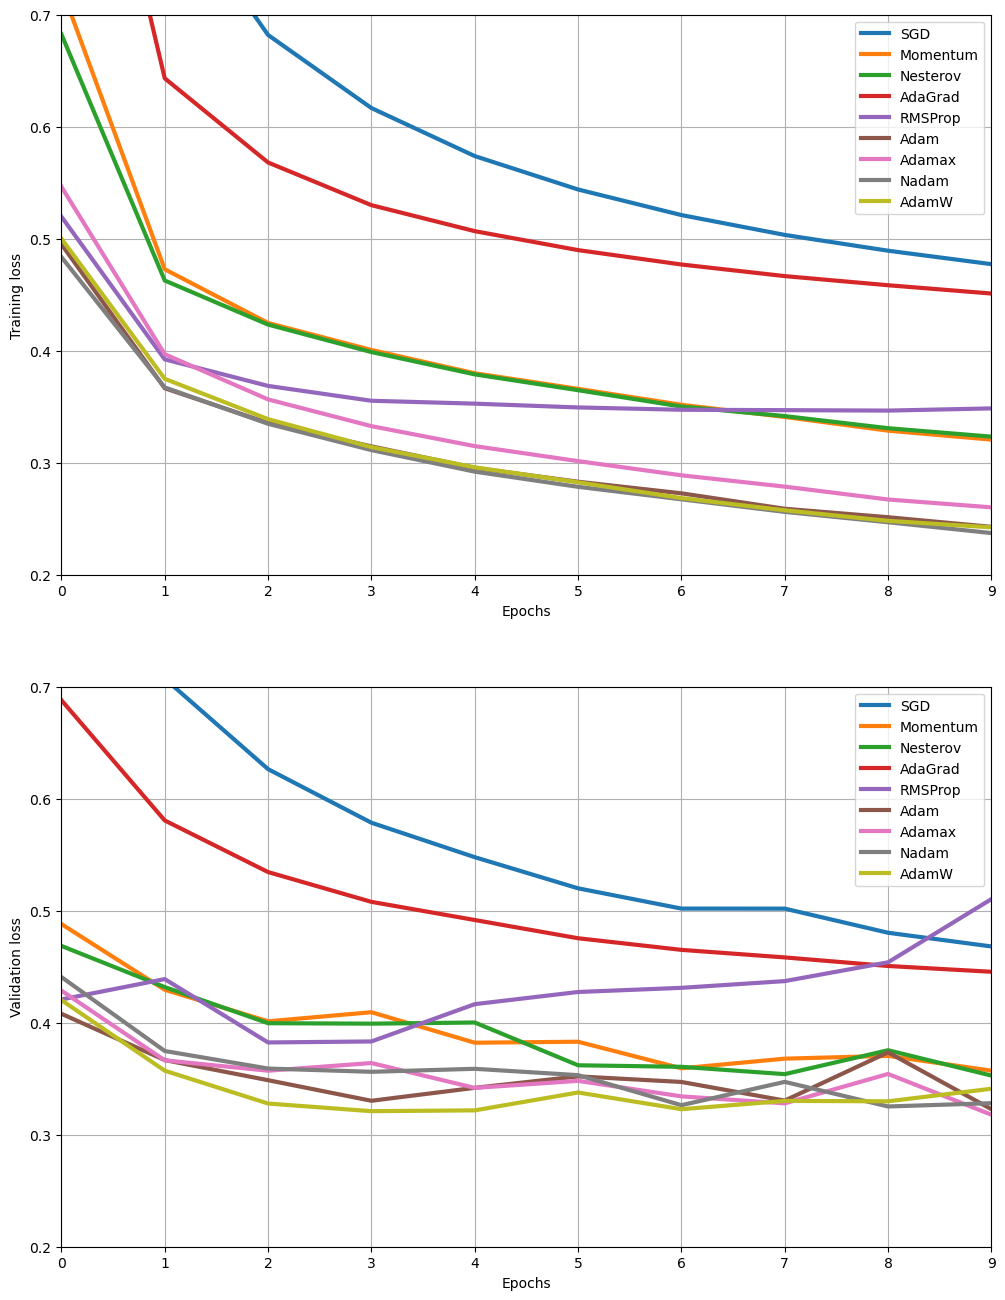

In [45]:
# 2. visualize the learning curves of all the optimizers
fig5, ax5 = plt.subplots(2,1, figsize=(12, 16))
for i, loss in enumerate(("loss", "val_loss")):  
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        ax5[i].plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    ax5[i].grid()
    ax5[i].set_xlabel("Epochs")
    ax5[i].set_ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    ax5[i].legend(loc="best")
    ax5[i].axis([0, 9, 0.2, 0.7])

Learning Rate (lr) Scheduling
---
- high lr may diverge
  - low lr takes a very long time to converge to the optimum
- `learning schedules` adjusts lr based on various strategies
- `Power scheduling` drops the lr at each iteration first quickly then more and more slowly
  - ${ η(k) = \dfrac{η_0} {(1 + k/s)^c} }$
  - η₀: initial learning rate, c: typically set to 1, and s: the steps, are hyperparameters
  - k: the iteration number
- `Exponential scheduling` drops the lr by a factor of 10 every s steps
  - ${ η(k) = η_0 10^{-k/s} }$
- `Piecewise constant scheduling` uses different constant lr's for different sections of epochs
- `Performance scheduling` reduces the lr by a factor of λ when the validation error stops dropping measured every N steps
- `1cycle (one cycle) scheduling` starts from a low η₀, grows linearly to η₁ ≈ 10η₀ halfway through training, then drops the lr linearly to η₀ during the second half of training

In [46]:
# 1. Power scheduling
#   learning_rate = initial_learning_rate / (1 + step / decay_steps)**power
#   power=1 in Keras
# The `InverseTimeDecay` scheduler uses 
# `learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)`. 
# If you set `staircase=True`, then it replaces
#  `step / decay_step` with `floor(step / decay_step)`.

lr_schedule1 = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer1 = tf.keras.optimizers.SGD(learning_rate=lr_schedule1)

history_power_scheduling = build_and_train_model(optimizer1)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6820 - accuracy: 0.7681 - val_loss: 0.5345 - val_accuracy: 0.8160
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4786 - accuracy: 0.8333 - val_loss: 0.4672 - val_accuracy: 0.8360
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4324 - accuracy: 0.8469 - val_loss: 0.4108 - val_accuracy: 0.8512
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4062 - accuracy: 0.8557 - val_loss: 0.3982 - val_accuracy: 0.8568
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3879 - accuracy: 0.8623 - val_loss: 0.3810 - val_accuracy: 0.8620
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3755 - accuracy: 0.8676 - val_loss: 0.3895 - val_accuracy: 0.8604
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3644 - accuracy: 0.8711 - val_loss: 0.4034 - val_accuracy:

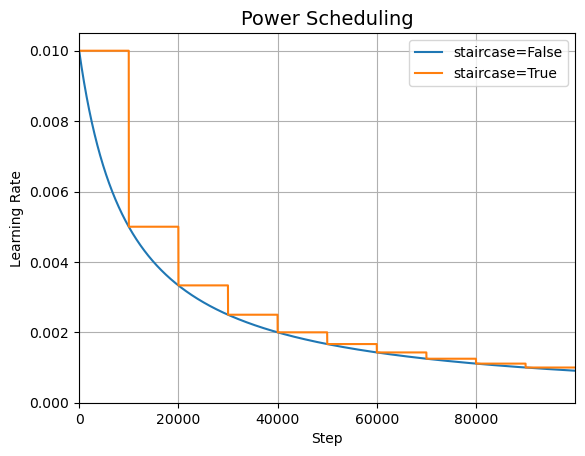

In [47]:
# visualize Power scheduling

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

fig6, ax6 = plt.subplots()
ax6.plot(steps, lrs,  "-", label="staircase=False")
ax6.plot(steps, lrs2,  "-", label="staircase=True")
ax6.axis([0, steps.max(), 0, 0.0105])
ax6.set_xlabel("Step")
ax6.set_ylabel("Learning Rate")
ax6.set_title("Power Scheduling", fontsize=14)
ax6.legend()
ax6.grid(True);

In [48]:
# 2. Exponential Scheduling
# learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)

lr_schedule2 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer2 = tf.keras.optimizers.SGD(learning_rate=lr_schedule2)

history_exponential_scheduling = build_and_train_model(optimizer2)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6959 - accuracy: 0.7627 - val_loss: 0.4929 - val_accuracy: 0.8212
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4702 - accuracy: 0.8347 - val_loss: 0.4558 - val_accuracy: 0.8362
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4253 - accuracy: 0.8506 - val_loss: 0.4240 - val_accuracy: 0.8458
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4009 - accuracy: 0.8585 - val_loss: 0.3986 - val_accuracy: 0.8538
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3842 - accuracy: 0.8645 - val_loss: 0.3970 - val_accuracy: 0.8584
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3723 - accuracy: 0.8684 - val_loss: 0.3817 - val_accuracy: 0.8600
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3628 - accuracy: 0.8712 - val_loss: 0.3787 - val_accuracy:

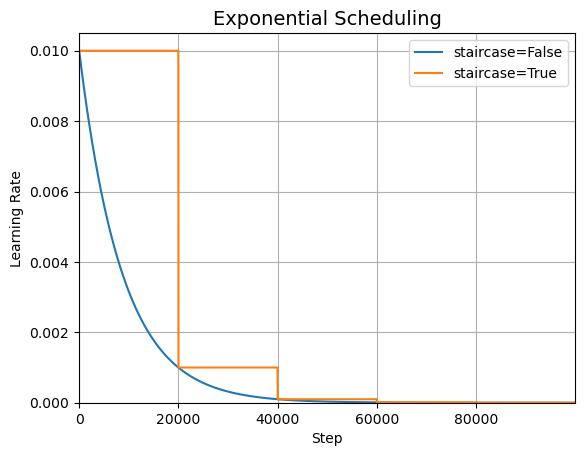

In [49]:
# visualize Exponential Scheduling
initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

fig7, ax7 = plt.subplots()
ax7.plot(steps, lrs,  "-", label="staircase=False")
ax7.plot(steps, lrs2,  "-", label="staircase=True")
ax7.axis([0, steps.max(), 0, 0.0105])
ax7.set_xlabel("Step")
ax7.set_ylabel("Learning Rate")
ax7.set_title("Exponential Scheduling", fontsize=14)
ax7.legend()
ax7.grid(True);

In [50]:
# 3. Define custom lr schedule with `LearningRateScheduler` callback class 
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

model = build_model()
optimizer3 = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer3,
              metrics=["accuracy"])

In [51]:
# train the model
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6793 - accuracy: 0.7669 - val_loss: 0.4960 - val_accuracy: 0.8234 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4696 - accuracy: 0.8342 - val_loss: 0.4311 - val_accuracy: 0.8440 - lr: 0.0089
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4233 - accuracy: 0.8500 - val_loss: 0.4022 - val_accuracy: 0.8544 - lr: 0.0079
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3951 - accuracy: 0.8595 - val_loss: 0.3863 - val_accuracy: 0.8642 - lr: 0.0071
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3747 - accuracy: 0.8662 - val_loss: 0.3719 - val_accuracy: 0.8674 - lr: 0.0063
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3602 - accuracy: 0.8724 - val_loss: 0.3787 - val_accuracy: 0.8626 - lr: 0.0056
Epoch 7/20
1719/1719 [==============================] - 4s

In [52]:
# 4. Piecewise Constant Scheduling
lr_schedule4 = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer4 = tf.keras.optimizers.SGD(learning_rate=lr_schedule4)

history_piecewise_scheduling = build_and_train_model(optimizer4)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7119 - accuracy: 0.7597 - val_loss: 0.4990 - val_accuracy: 0.8204
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4747 - accuracy: 0.8348 - val_loss: 0.4427 - val_accuracy: 0.8444
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4282 - accuracy: 0.8491 - val_loss: 0.4161 - val_accuracy: 0.8522
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3973 - accuracy: 0.8581 - val_loss: 0.3899 - val_accuracy: 0.8568
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3767 - accuracy: 0.8661 - val_loss: 0.3740 - val_accuracy: 0.8674
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3604 - accuracy: 0.8713 - val_loss: 0.3696 - val_accuracy: 0.8654
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3471 - accuracy: 0.8760 - val_loss: 0.3569 - val_accuracy:

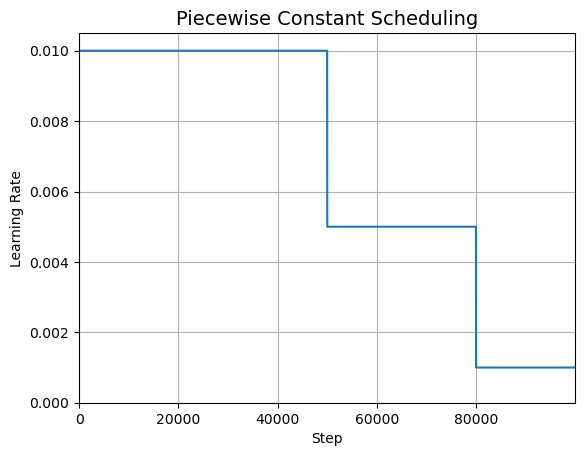

In [53]:
# plots piecewise constant scheduling

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

fig8, ax8 = plt.subplots()
ax8.plot(steps, lrs, "-")
ax8.axis([0, steps.max(), 0, 0.0105])
ax8.set_xlabel("Step")
ax8.set_ylabel("Learning Rate")
ax8.set_title("Piecewise Constant Scheduling", fontsize=14)
ax8.grid(True);

In [62]:
# implement piecewise constant scheduling manually:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001
    
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001]) 

n_epochs = 25

lr_schedulerx = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
lr0 = 0.01
optimizerx = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizerx,
              metrics=["accuracy"])
historyx = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_schedulerx])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5439 - accuracy: 0.8096 - val_loss: 0.4584 - val_accuracy: 0.8414 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4578 - accuracy: 0.8397 - val_loss: 0.4540 - val_accuracy: 0.8458 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4295 - accuracy: 0.8489 - val_loss: 0.4498 - val_accuracy: 0.8468 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4213 - accuracy: 0.8534 - val_loss: 0.4329 - val_accuracy: 0.8606 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4145 - accuracy: 0.8557 - val_loss: 0.4261 - val_accuracy: 0.8604 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3617 - accuracy: 0.8720 - val_loss: 0.4246 - val_accuracy: 0.8514 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 3s

In [55]:
# explore `tf.keras.optimizers.schedules`

for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

• CosineDecay – A LearningRateSchedule that uses a cosine decay with optional warmup.
• CosineDecayRestarts – A LearningRateSchedule that uses a cosine decay schedule with restarts.
• ExponentialDecay – A LearningRateSchedule that uses an exponential decay schedule.
• InverseTimeDecay – A LearningRateSchedule that uses an inverse time decay schedule.
• LearningRateSchedule – The learning rate schedule base class.
• PiecewiseConstantDecay – A LearningRateSchedule that uses a piecewise constant decay schedule.
• PolynomialDecay – A LearningRateSchedule that uses a polynomial decay schedule.


In [63]:
# 5. Performance Scheduling
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])


lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6985 - accuracy: 0.7576 - val_loss: 0.4865 - val_accuracy: 0.8264 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4693 - accuracy: 0.8344 - val_loss: 0.4477 - val_accuracy: 0.8392 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4224 - accuracy: 0.8507 - val_loss: 0.3985 - val_accuracy: 0.8560 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3948 - accuracy: 0.8598 - val_loss: 0.3833 - val_accuracy: 0.8600 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3738 - accuracy: 0.8667 - val_loss: 0.3688 - val_accuracy: 0.8622 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3590 - accuracy: 0.8725 - val_loss: 0.3558 - val_accuracy: 0.8694 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 4s

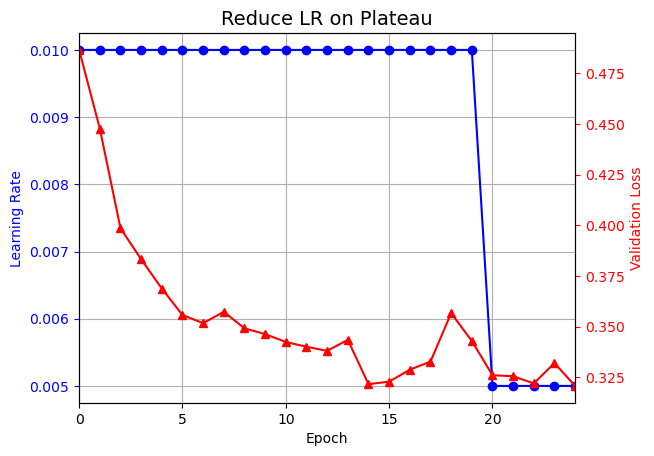

In [64]:
# plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14);

In [66]:
# 6. 1Cycle scheduling
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)
        
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()        

430/430 [==============================] - 2s 4ms/step - loss: 1.8292 - accuracy: 0.3587


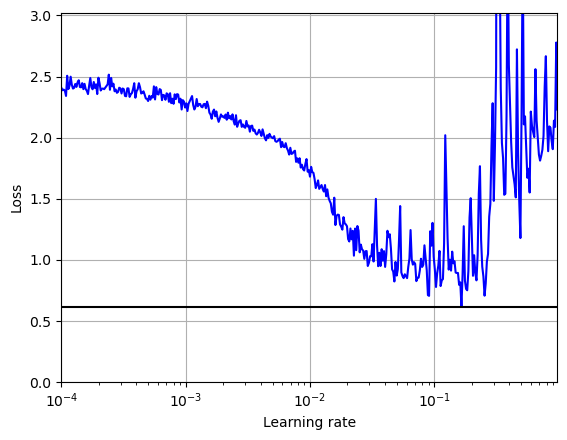

In [67]:

model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [68]:
# 

class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)    

In [69]:

model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 5ms/step - loss: 0.9814 - accuracy: 0.6828 - val_loss: 0.6113 - val_accuracy: 0.7906
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.5682 - accuracy: 0.8020 - val_loss: 0.6653 - val_accuracy: 0.7424
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4928 - accuracy: 0.8255 - val_loss: 0.4736 - val_accuracy: 0.8302
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4531 - accuracy: 0.8388 - val_loss: 0.4924 - val_accuracy: 0.8292
Epoch 5/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4222 - accuracy: 0.8481 - val_loss: 0.4379 - val_accuracy: 0.8492
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.4023 - accuracy: 0.8564 - val_loss: 0.4925 - val_accuracy: 0.8228
Epoch 7/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3849 - accuracy: 0.8610 - val_loss: 0.3913 - val_accuracy: 0.8626
Epoch 

# Avoiding Overfitting Through Regularization
- with huge number of parameters, NNs are prone to overfitting the training set
  - which can be prevented by regularization
- popular regularization techniques for NNs: 
  - ${\ell_1}$ and ${\ell_2}$ regularization, dropout, and max-norm regularization
- even though batch normalization was designed to solve the unstable gradients problems
  - it also acts like a pretty good regularizer

${\ell_1}$ and ${\ell_2}$ regularization
---
- ${\ell_1}$ generates  a sparse model by zeroing out many weights
- ${\ell_2}$ constrains a NN’s connection weights

In [70]:
# 1. apply ℓ₁ and ℓ₂ regularization
# - `l2(0.01)` for ℓ₂ regularization with a factor of 0.01
# - `l1(0.1)` for ℓ₁ regularization with a factor of 0.1, 
# - or `l1_l2(0.1, 0.01)` for both ℓ₁ and ℓ₂ regularization, 
#       with factors 0.1 and 0.01 respectively.

layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

# Python’s functools.partial() function,
# lets you create a thin wrapper for any callable, 
# with some default argument values:

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [71]:
# 2. compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 3s 2ms/step - loss: 3.1372 - accuracy: 0.7721 - val_loss: 1.8625 - val_accuracy: 0.8198
Epoch 2/2
1719/1719 [==============================] - 3s 2ms/step - loss: 1.4310 - accuracy: 0.8127 - val_loss: 1.1227 - val_accuracy: 0.8198


dropout
---
- one of the most popular regularization techniques for DNNs
- algorithm:
  - at every training step, every neuron has a probability p of being temporarily “dropped out”
    - entirely ignored during this training step
      - the dropped-out neuron outputs 0 at this iteration
    - but it may be active during the next step
    - including the input neurons, but always excluding the output neurons
  - The hyperparameter p is called the `dropout rate`
    - typically set between 10% and 50%
      - closer to 20%–30% in recurrent neural nets
      - closer to 40%–50% in convolutional neural networks
  - we need to divide the connection weights by the keep probability (1 – p) during training
    - ∵ a neuron would be connected to 1/(1 – p) as many input neurons as it would be during training
  - After training, neurons don’t get dropped anymore
- the power of dropout comes from 
  - a unique nn is generated at each training step
  - since each neuron can be either present or absent so there are a total of `2ᴺ` possible networks
    - such a huge number that it is virtually impossible for the same nn to be sampled twice
  - The resulting nn can be seen as an averaging ensemble of all these smaller nn's

In [72]:
# 1. apply dropout regularization by adding a Dropout layer
#    after each layer except the output layer
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [73]:
# 2. compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6767 - accuracy: 0.7542 - val_loss: 0.4512 - val_accuracy: 0.8398
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5091 - accuracy: 0.8139 - val_loss: 0.4235 - val_accuracy: 0.8406
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4732 - accuracy: 0.8269 - val_loss: 0.3835 - val_accuracy: 0.8584
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4513 - accuracy: 0.8356 - val_loss: 0.3837 - val_accuracy: 0.8642
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4343 - accuracy: 0.8398 - val_loss: 0.3767 - val_accuracy: 0.8616
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4229 - accuracy: 0.8441 - val_loss: 0.3693 - val_accuracy: 0.8652
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4121 - accuracy: 0.8484 - val_loss: 0.3583 - val_accuracy:

In [74]:
# performance of the model
model.evaluate(X_train, y_train), model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3669 - accuracy: 0.8658


([0.30828940868377686, 0.8848181962966919],
 [0.36693495512008667, 0.8658000230789185])

Monte Carlo (MC) Dropout
---
- can boost the performance of any trained dropout model without having to retrain it or even modify it at all
- provides a much better measure of the model’s uncertainty

In [75]:
# 1. boost the dropout model we trained earlier without retraining it
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [76]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8689

max-norm
---
